<a href="https://colab.research.google.com/github/BDFL669/Data_Analysis_with_R/blob/main/decisionTrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Decision Trees and Random Forest in R Programming

In this section, the process of constructing predictive models in R using the party, rpart, and randomForest packages is demonstrated. The chapter commences by constructing decision trees using the party package and employing the generated tree for classification purposes. Subsequently, an alternative approach to constructing decision trees using the rpart package is introduced. Finally, an example is provided to showcase the training of a random forest model using the randomForest package.

##Decision Trees using Package party

This section illustrates the process of constructing a decision tree for the iris data using the ctree() function from the party package. More specifically, the features Sepal.Length, Sepal.Width, Petal.Length, and Petal.Width are utilized to predict the species of flowers. The ctree() function within the package builds the decision tree, while predict() enables predictions for new data. Prior to modeling, the iris data is divided into two subsets: training (70%) and test (30%). To ensure reproducibility of the results, a fixed value is set for the random seed.

In [2]:
install.packages('party')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘TH.data’, ‘libcoin’, ‘matrixStats’, ‘multcomp’, ‘mvtnorm’, ‘modeltools’, ‘strucchange’, ‘coin’, ‘zoo’, ‘sandwich’




In [3]:
str(iris)

'data.frame':	150 obs. of  5 variables:
 $ Sepal.Length: num  5.1 4.9 4.7 4.6 5 5.4 4.6 5 4.4 4.9 ...
 $ Sepal.Width : num  3.5 3 3.2 3.1 3.6 3.9 3.4 3.4 2.9 3.1 ...
 $ Petal.Length: num  1.4 1.4 1.3 1.5 1.4 1.7 1.4 1.5 1.4 1.5 ...
 $ Petal.Width : num  0.2 0.2 0.2 0.2 0.2 0.4 0.3 0.2 0.2 0.1 ...
 $ Species     : Factor w/ 3 levels "setosa","versicolor",..: 1 1 1 1 1 1 1 1 1 1 ...


In [4]:
set.seed(1234)
ind <- sample(2, nrow(iris), replace=TRUE, prob=c(0.7, 0.3))
trainData <- iris[ind==1,]
testData <- iris[ind==2,]


The code below shows how to load the party package and build the decision tree model before outputting the prediction result. myFormula outlines our target variable (Species) while initializing the other variables as independent parameters.

In [5]:
library(party)
myFormula <- Species ~ Sepal.Length + Sepal.Width + Petal.Length + Petal.Width
iris_ctree <- ctree(myFormula, data=trainData)
# check the prediction
table(predict(iris_ctree), trainData$Species)

Loading required package: grid

Loading required package: mvtnorm

Loading required package: modeltools

Loading required package: stats4

Loading required package: strucchange

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich



            
             setosa versicolor virginica
  setosa         40          0         0
  versicolor      0         37         3
  virginica       0          1        31

Now let us explore our built tree using the print function to output the rules and by plotting the tree.


In [6]:
print(iris_ctree)


	 Conditional inference tree with 4 terminal nodes

Response:  Species 
Inputs:  Sepal.Length, Sepal.Width, Petal.Length, Petal.Width 
Number of observations:  112 

1) Petal.Length <= 1.9; criterion = 1, statistic = 104.643
  2)*  weights = 40 
1) Petal.Length > 1.9
  3) Petal.Width <= 1.7; criterion = 1, statistic = 48.939
    4) Petal.Length <= 4.4; criterion = 0.974, statistic = 7.397
      5)*  weights = 21 
    4) Petal.Length > 4.4
      6)*  weights = 19 
  3) Petal.Width > 1.7
    7)*  weights = 32 


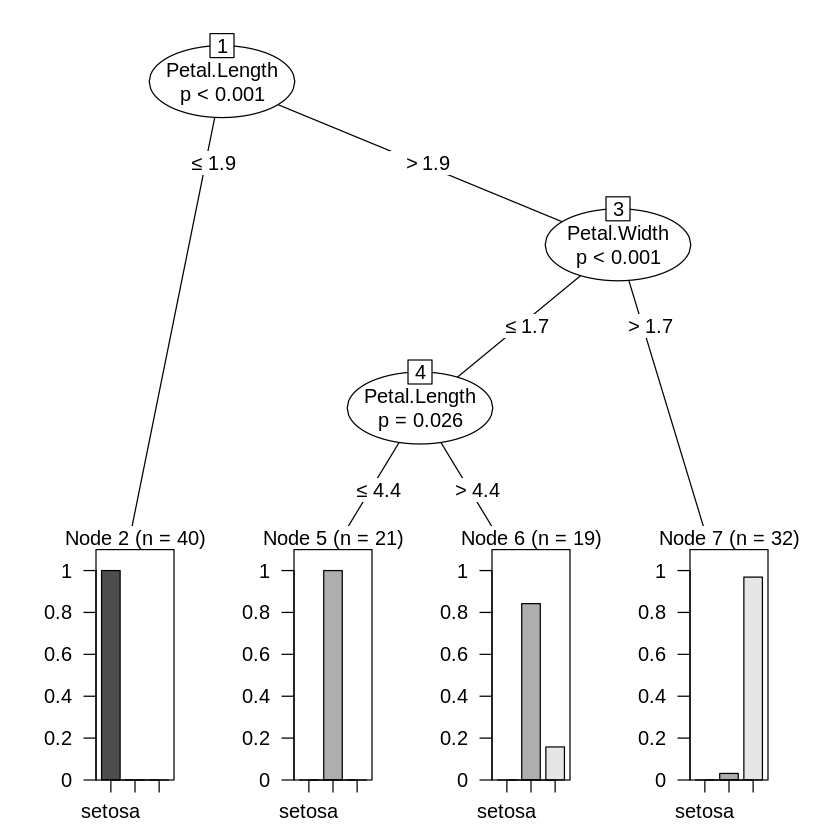

In [7]:
plot(iris_ctree)

In the figure above, the bar plot representing each terminal point exhibits the likelihoods of an occurrence being assigned to the three distinct categories. In the figure below, these probabilities are represented as "y" within the nodes. To illustrate, node 2 is denoted as "n=40, y=(1, 0, 0)," indicating the presence of 40 training occurrences, all of which pertain to the initial category, "setosa." Next, the constructed tree must undergo testing using test data.

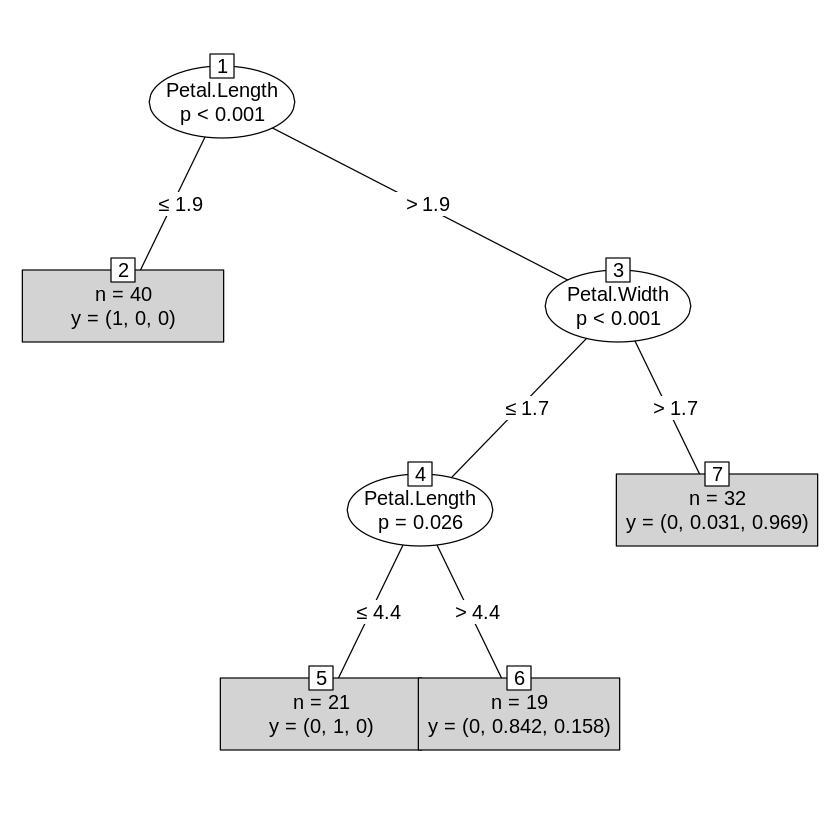

In [8]:
plot(iris_ctree, type="simple")

In [9]:
# predict on test data
testPred <- predict(iris_ctree, newdata = testData)
table(testPred, testData$Species)

            
testPred     setosa versicolor virginica
  setosa         10          0         0
  versicolor      0         12         2
  virginica       0          0        14

The current iteration of the ctree() function (specifically, version 0.9-9995) lacks robust handling of missing values. In this case, an instance with a missing value may be assigned to either the left or right sub-tree inconsistently, possibly due to surrogate rules.

Another concern arises when a variable is present in the training data and provided to ctree(), but does not appear in the constructed decision tree. In such instances, the test data must also contain that variable in order for predictions to be made successfully using the predict() function. Additionally, if the categorical variable levels in the test data differ from those in the training data, prediction on the test data will fail.

To address the aforementioned issues, one possible solution is to construct a new decision tree using ctree() after the initial tree is built. This new tree should only include variables that exist in the first tree. Furthermore, it is essential to explicitly set the categorical variable levels in the test data to match the corresponding variable levels in the training data.

## Decision Trees with Package rpart

To mix things up a little, we will use the bodyfat dataset alongside rpart package to create a decision tree model. rpart() helps us build the model so that we can select the decision tree with the least predcition error. Thereafter, we apply the model to data it has never seen before and generate prections using the usual suspect: predict(). But first things first, let us load the bodyfat dataset.

In [11]:
#the TH.data package has to be installed to gain access to the BodyFat dataset
install.packages("TH.data", repos = "http://cran.r-project.org")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [14]:
data("bodyfat", package = "TH.data")
dim(bodyfat)

[1] 71 10

In [15]:
attributes(bodyfat)

$names
 [1] "age"          "DEXfat"       "waistcirc"    "hipcirc"      "elbowbreadth"
 [6] "kneebreadth"  "anthro3a"     "anthro3b"     "anthro3c"     "anthro4"     

$row.names
 [1] "47"  "48"  "49"  "50"  "51"  "52"  "53"  "54"  "55"  "56"  "57"  "58" 
[13] "59"  "60"  "61"  "62"  "63"  "64"  "65"  "66"  "67"  "68"  "69"  "70" 
[25] "71"  "72"  "73"  "74"  "75"  "76"  "77"  "78"  "79"  "80"  "81"  "82" 
[37] "83"  "84"  "85"  "86"  "87"  "88"  "89"  "90"  "91"  "92"  "93"  "94" 
[49] "95"  "96"  "97"  "98"  "99"  "100" "101" "102" "103" "104" "105" "106"
[61] "107" "108" "109" "110" "111" "112" "113" "114" "115" "116" "117"

$class
[1] "data.frame"

In [16]:
bodyfat[1:5,]

,age,DEXfat,waistcirc,hipcirc,elbowbreadth,kneebreadth,anthro3a,anthro3b,anthro3c,anthro4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
47,57,41.68,100.0,112.0,7.1,9.4,4.42,4.95,4.50,6.13
48,65,43.29,99.5,116.5,6.5,8.9,4.63,5.01,4.48,6.37
49,59,35.41,96.0,108.5,6.2,8.9,4.12,4.74,4.60,5.82
50,58,22.79,72.0,96.5,6.1,9.2,4.03,4.48,3.91,5.66
51,60,36.42,89.5,100.5,7.1,10.0,4.24,4.68,4.15,5.91


The following code splits the datasets into the test and train subsets before a decision tree model is built using the latter subset.

In [18]:
set.seed(1234)
ind <- sample(2, nrow(bodyfat), replace=TRUE, prob=c(0.7, 0.3))
bodyfat.train <- bodyfat[ind==1,]
bodyfat.test <- bodyfat[ind==2,]
# train a decision tree
library(rpart)
myFormula <- DEXfat ~ age + waistcirc + hipcirc + elbowbreadth + kneebreadth
bodyfat_rpart <- rpart(myFormula, data = bodyfat.train, control = rpart.control(minsplit = 10))
attributes(bodyfat_rpart)

$names
 [1] "frame"               "where"               "call"               
 [4] "terms"               "cptable"             "method"             
 [7] "parms"               "control"             "functions"          
[10] "numresp"             "splits"              "variable.importance"
[13] "y"                   "ordered"            

$xlevels
named list()

$class
[1] "rpart"

In [19]:
print(bodyfat_rpart$cptable)

          CP nsplit  rel error    xerror       xstd
1 0.67272638      0 1.00000000 1.0427457 0.19016187
2 0.09390665      1 0.32727362 0.5081173 0.11702581
3 0.06037503      2 0.23336696 0.4522296 0.09801847
4 0.03420446      3 0.17299193 0.3967005 0.09676249
5 0.01708278      4 0.13878747 0.3015476 0.07385485
6 0.01695763      5 0.12170469 0.2929969 0.06850104
7 0.01007079      6 0.10474706 0.2713231 0.06690466
8 0.01000000      7 0.09467627 0.2713231 0.06690466


In [20]:
 print(bodyfat_rpart)

n= 56 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 56 7265.0290000 30.94589  
   2) waistcirc< 88.4 31  960.5381000 22.55645  
     4) hipcirc< 96.25 14  222.2648000 18.41143  
       8) age< 60.5 9   66.8809600 16.19222 *
       9) age>=60.5 5   31.2769200 22.40600 *
     5) hipcirc>=96.25 17  299.6470000 25.97000  
      10) waistcirc< 77.75 6   30.7345500 22.32500 *
      11) waistcirc>=77.75 11  145.7148000 27.95818  
        22) hipcirc< 99.5 3    0.2568667 23.74667 *
        23) hipcirc>=99.5 8   72.2933500 29.53750 *
   3) waistcirc>=88.4 25 1417.1140000 41.34880  
     6) waistcirc< 104.75 18  330.5792000 38.09111  
      12) hipcirc< 109.9 9   68.9996200 34.37556 *
      13) hipcirc>=109.9 9   13.0832000 41.80667 *
     7) waistcirc>=104.75 7  404.3004000 49.72571 *


Let us visualize the built tree

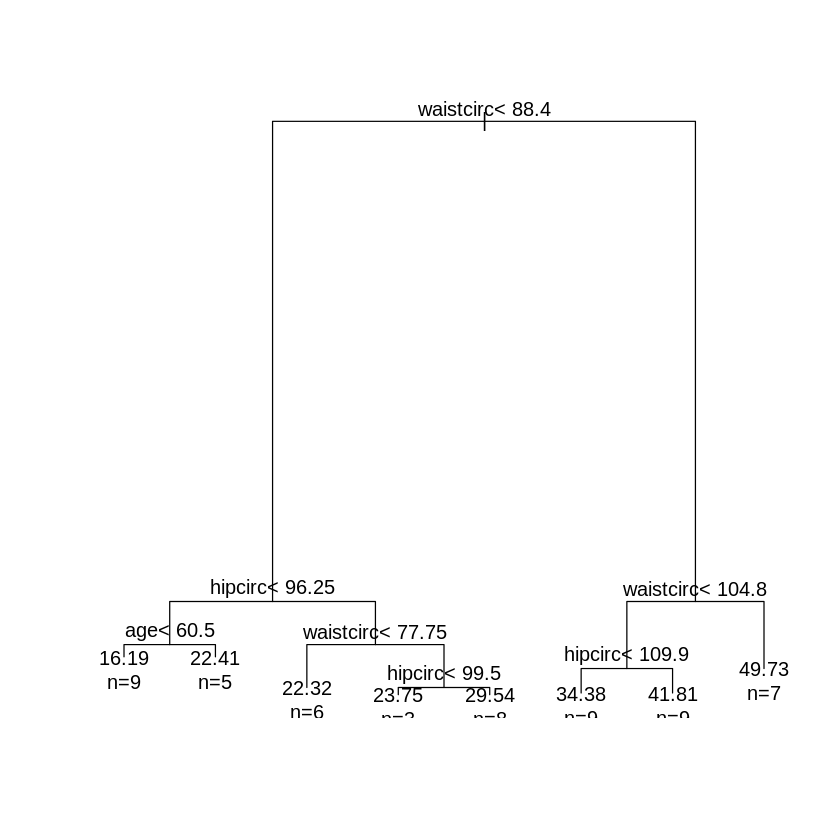

In [21]:
plot(bodyfat_rpart)
text(bodyfat_rpart, use.n=T)

Now let us identify the one with the least error rate

In [22]:
opt <- which.min(bodyfat_rpart$cptable[,"xerror"])
cp <- bodyfat_rpart$cptable[opt, "CP"]
bodyfat_prune <- prune(bodyfat_rpart, cp = cp)
print(bodyfat_prune)

n= 56 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 56 7265.02900 30.94589  
   2) waistcirc< 88.4 31  960.53810 22.55645  
     4) hipcirc< 96.25 14  222.26480 18.41143  
       8) age< 60.5 9   66.88096 16.19222 *
       9) age>=60.5 5   31.27692 22.40600 *
     5) hipcirc>=96.25 17  299.64700 25.97000  
      10) waistcirc< 77.75 6   30.73455 22.32500 *
      11) waistcirc>=77.75 11  145.71480 27.95818 *
   3) waistcirc>=88.4 25 1417.11400 41.34880  
     6) waistcirc< 104.75 18  330.57920 38.09111  
      12) hipcirc< 109.9 9   68.99962 34.37556 *
      13) hipcirc>=109.9 9   13.08320 41.80667 *
     7) waistcirc>=104.75 7  404.30040 49.72571 *


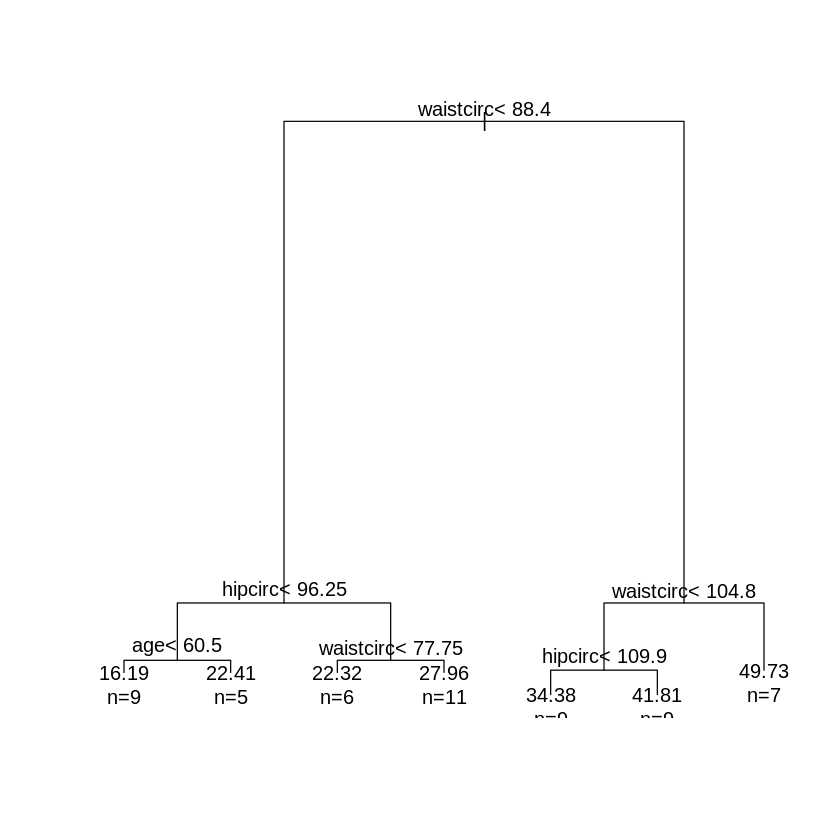

In [23]:
plot(bodyfat_prune)
text(bodyfat_prune, use.n=T)

We can now use the best tree predict values and compare them to the real values in the bodyfat dataset. The following code uses abline() to draw a diagonal line. If the model is good enough then most of the points should be on or next to this line that represents the actual values.

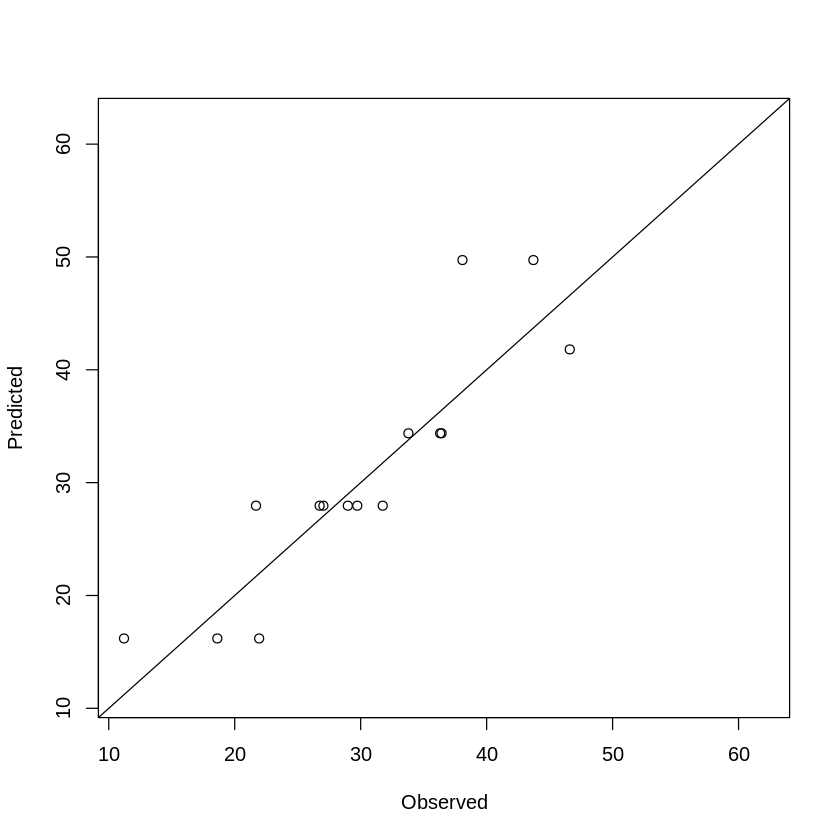

In [24]:
DEXfat_pred <- predict(bodyfat_prune, newdata=bodyfat.test)
xlim <- range(bodyfat$DEXfat)
plot(DEXfat_pred ~ DEXfat, data=bodyfat.test, xlab="Observed", ylab="Predicted", ylim=xlim, xlim=xlim)
abline(a=0, b=1)


##Random Forest

Finally, let us install the randomForest package for our next predicitive model that will use the iris dataset. Unfortunately, randomForest cannot handle datasets with missing values. Moreover, every categorical variable can only have a maximum number of 32 levels. If the levels exceed 32, transformation prior to feeding data is pertinent. You can also leverage package party's cforest() function as it does not limit categorical attributes to 32 levles. Nonetheless, you'll still end up using more memory and spend a lot of time training the model when you have too many levels. We begin by splitting the dataset into training and test subsets.

In [25]:
ind <- sample(2, nrow(iris), replace=TRUE, prob=c(0.7, 0.3))
trainData <- iris[ind==1,]
testData <- iris[ind==2,]

The code below loads the required package and begins the training process. The logic is pretty much the same as in the other instances.


In [27]:
install.packages('randomForest') # For generating random forest model

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [28]:
library(randomForest)
rf <- randomForest(Species ~ ., data=trainData, ntree=100, proximity=TRUE)
table(predict(rf), trainData$Species)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.



            
             setosa versicolor virginica
  setosa         33          0         0
  versicolor      0         33         2
  virginica       0          2        35

In [29]:
print(rf)


Call:
 randomForest(formula = Species ~ ., data = trainData, ntree = 100,      proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 2

        OOB estimate of  error rate: 3.81%
Confusion matrix:
           setosa versicolor virginica class.error
setosa         33          0         0  0.00000000
versicolor      0         33         2  0.05714286
virginica       0          2        35  0.05405405


In [31]:
attributes(rf)

$names
 [1] "call"            "type"            "predicted"       "err.rate"       
 [5] "confusion"       "votes"           "oob.times"       "classes"        
 [9] "importance"      "importanceSD"    "localImportance" "proximity"      
[13] "ntree"           "mtry"            "forest"          "y"              
[17] "test"            "inbag"           "terms"          

$class
[1] "randomForest.formula" "randomForest"

After that, we plot the error rates with various number of trees.


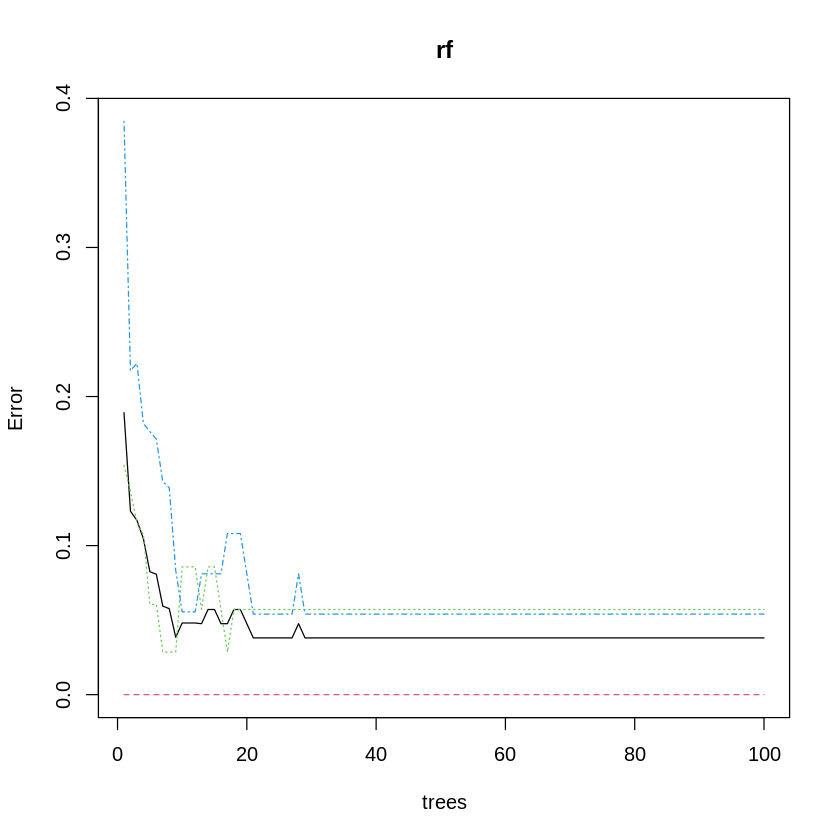

In [32]:
plot(rf)

,MeanDecreaseGini
Sepal.Length,7.435541
Sepal.Width,2.225215
Petal.Length,27.629030
Petal.Width,31.926785


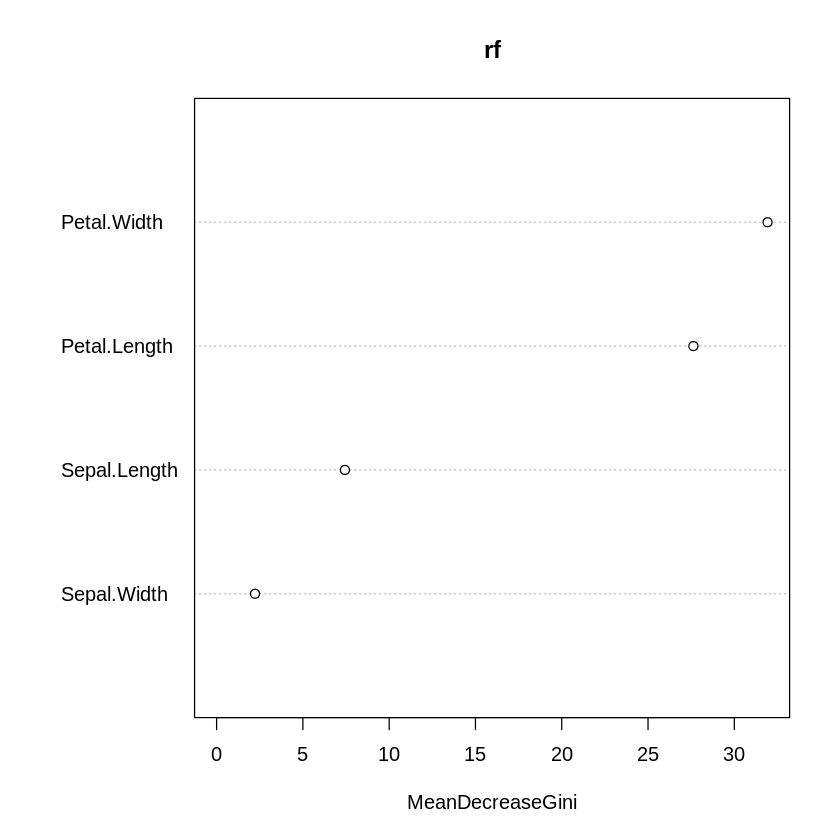

In [34]:
importance(rf)
varImpPlot(rf)

Finally, the built random forest is tested on test data, and the result is checked with functions
table() and margin(). The margin of a data point is as the proportion of votes for the correct
class minus maximum proportion of votes for other classes. Generally speaking, positive margin means correct classification.

In [35]:
irisPred <- predict(rf, newdata=testData)
table(irisPred, testData$Species)

            
irisPred     setosa versicolor virginica
  setosa         17          0         0
  versicolor      0         15         2
  virginica       0          0        11

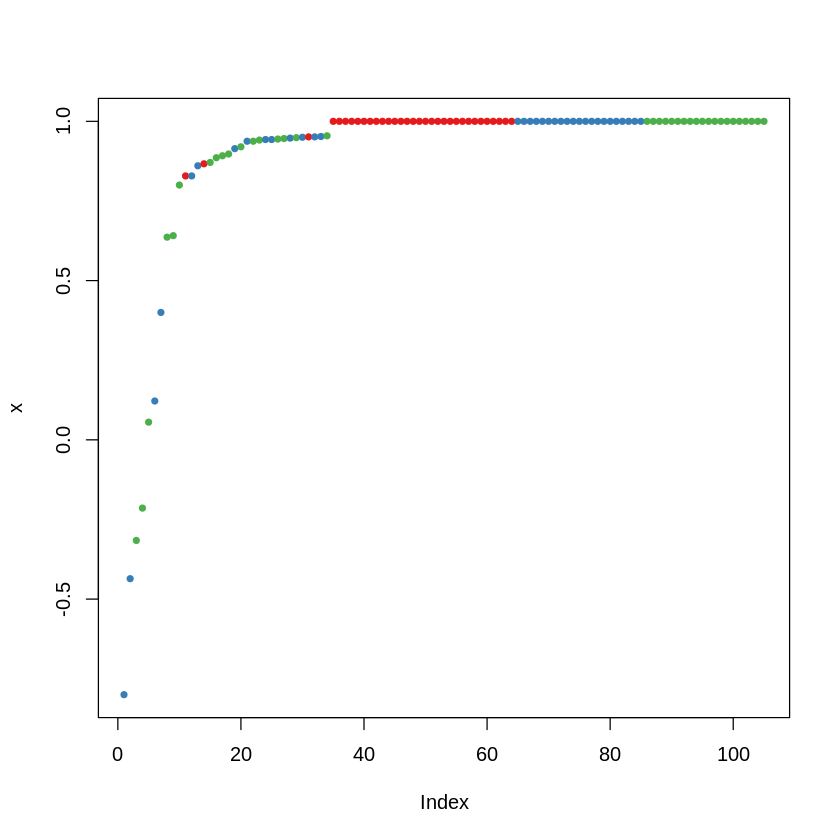

In [36]:
plot(margin(rf, testData$Species))